### SARIMA MODELLING AND FORECASTING

<p>We have been provided monthly sales data from a well known Australian retail chain. The data ranges from April 1982 to December 2014. Management has asked us to estimate Sales for the next two years, or specifically, the next 24 steps.</p>
    
<p>To perform this task, we will identify the appropriate SARIMAX model and fit it to our data. We will then use the model to make our forecast. SARIMAX stands for Seasonal Auto-Regressive Integrated Moving Average model with eXogenous factors. The formula for a SARIMAX model looks like this:</p>

<p>&emsp;&emsp;<b>SARIMA (p,d,q) * (P,D,Q,S)</b></p>

<p>Where:
<li>The Autoregressive term <b>AR(p)</b>: the portion of the model that is a function of the sum of (p) past values;
<li>The Moving Average term <b>MA(q)</b>: the portion of the model that is a function of a weighted sum of past residuals (q);
<li>The Integrated term <b>(d)</b>: the time series  has been differences (d) times to ensure a stationary series;
<li>The Seasonal term <b>(S)</b>: denoted in capitals, the seasonal AR and MA order of the model, as well as the length of the seasonal cycle (S). Eg; the yearly cycle found in our time series would be denoted as S=12.</p>
<p>&emsp;</p>
<p>We tackle this problem using the Box-Jenkins method, taking raw data and using it for production purposes.</p>
<li>Identification - determining if the time series is appropriate in it's current form, or if it requires transforming due to non-stationarity
<li>Estimation - determining the most appropriate AR and MA coefficients for the model, fitting them and measuring thier accuracy
<li>Model Diagnostics - running diagnostics on the performance of our model; are the residuals normal and uncorrelated?

In [22]:
#Import the necessary Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

### Identification

<p>We start by importing our Sales Data, saves as RetailData. We will import this from a csv file to a Pandas Dataframe that can be used for manipulation, EDA, model fitting and finally for forecasting.<p/>
<p>After importing the time series data and visualising the unaltered obsevations, we can see see that the data is non-statiuonary in its current form. 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393 entries, 1982-04-01 to 2014-12-01
Data columns (total 1 columns):
Turnover    393 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB
None
            Turnover
Month               
1982-04-01      15.6
1982-05-01      15.8
1982-06-01      15.2
1982-07-01      15.2
1982-08-01      14.5
            Turnover
Month               
2014-08-01      69.8
2014-09-01      85.3
2014-10-01      73.9
2014-11-01      94.2
2014-12-01     154.9


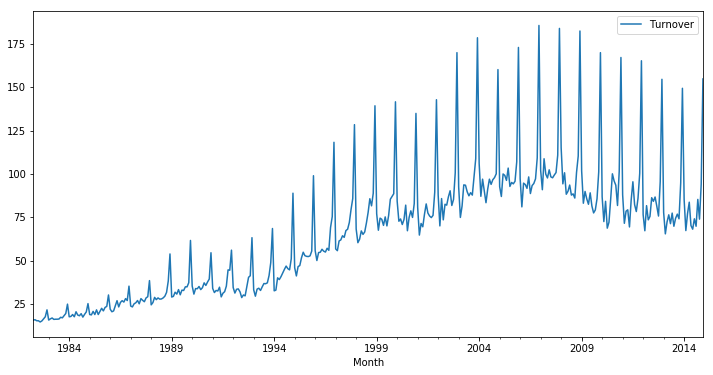

In [23]:
#Importing our Sales Data from a csv file into a Pandas Dataframe.
df = pd.read_csv('RetailData.csv', index_col='Student.ID', header=0, usecols=['Student.ID','26026813'], skiprows=[1,2,3,4])
df.columns=['Turnover']
df.index.names = ['Month']
df.index = pd.to_datetime(df.index, format = '%b-%y')

print(df.info())
print(df.head())
print(df.tail())
df.plot()
plt.show()

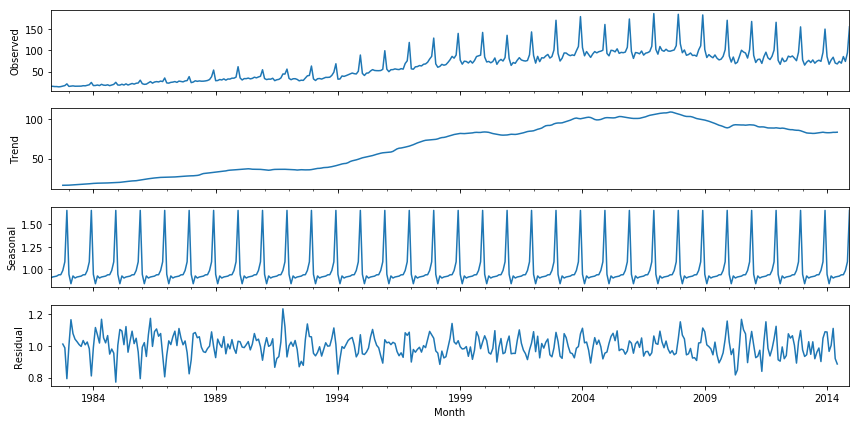

In [24]:
#Perform seasonal decomposition of our time series, 
#allowing us to visualise the trend component, seasonal component and the residual component.
from statsmodels.tsa.seasonal import seasonal_decompose
m_decomp_results = seasonal_decompose(df, freq=12, model='multiplicative')

m_decomp_results.plot()
plt.show()

<p>At a glance, this time series does not appear to be stationary. A stationary time series will satisfy three criteria;<p/> 
<li>Zero trend; there is a clear upwards trend for the majority of the series,
<li>Constant variance; the increasing seasonal component violates this, as well as the non stationary noise that can be seen between the seasonal peaks,
<li>Constant autocorrelation; this can be investigated further using the Autocorrelation and Partial-autocorrelation functions.
<p>
<p>We will perform an <b>Augmented Dickey Fuller</b> test on this series and comment on the results. The ADF tests the null hypothesis that a unit-root is present in the time series. If the null hypothesis of the ADF test cannot be rejected, the time series contains a unit root and is non-stationary. A time series that is non-stationary will cause issues with forecasting, and so we will need to work around this.<p/>

In [25]:
#Import Augmented Dickey Fuller test from statsmodels package
from statsmodels.tsa.stattools import adfuller

#H0: Time series is non-stationary
#H1: Time series is stationary
def adf_test(data):
	result=adfuller(data)
	labels=['Test Statistic','p-value','T-n (Lags)','# of Obersvations']
	for value,label in zip(result,labels):
		print(label+' : '+str(value))
	if result[1] <= 0.05:
		print("Reject null hypothesis, time series is stationary, no indication of unit root in the data")
	else:
		print("Cannot reject null hypothesis, time series is non-stationary, data has a unit root")

In [26]:
adf_test(df['Turnover'])

Test Statistic : -1.6094659419705835
p-value : 0.4788369024325966
T-n (Lags) : 16
# of Obersvations : 376
Cannot reject null hypothesis, time series is non-stationary, data has a unit root


<p>From the above ADF test, a p-value of 0.47 indicates weak evidence against the null hypothesis of a unit root within the time series, and therefore we cannot reject it.</p>

<p>We therefore continue with our time series on the assumption that it is non-stationary. Because of this, we will need to take the first difference of the series until the data is stationary.</p>

            Turnover
Month               
1983-05-01 -0.006508
1983-06-01  0.038715
1983-07-01  0.006192
1983-08-01  0.107045
1983-09-01 -0.058142


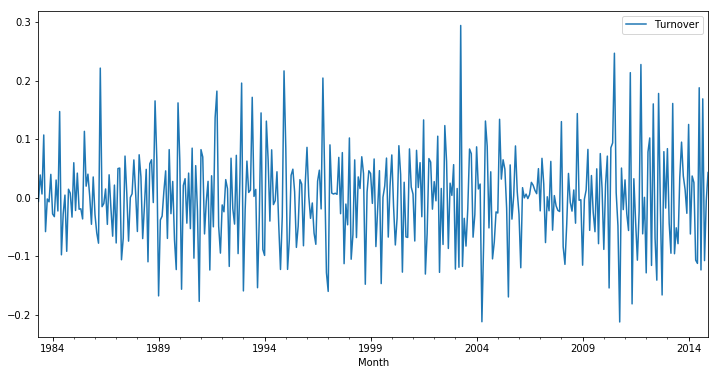

In [27]:
#Taking the first difference of our time series to attempt to create a stationary series
df_log = np.log(df)
df_diff = df_log.diff().diff(12).dropna()
print(df_diff.head())
df_diff.plot()

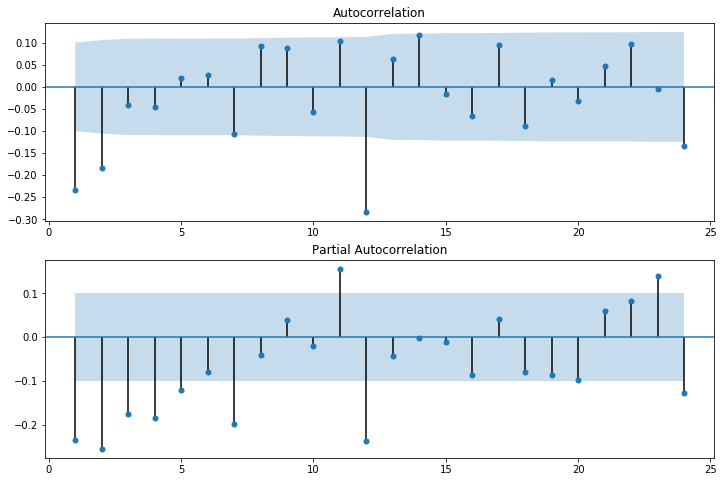

In [28]:
#Plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_diff, lags=24, zero=False, ax=ax1)
plot_pacf(df_diff, lags=24, zero=False, ax=ax2)
plt.show()

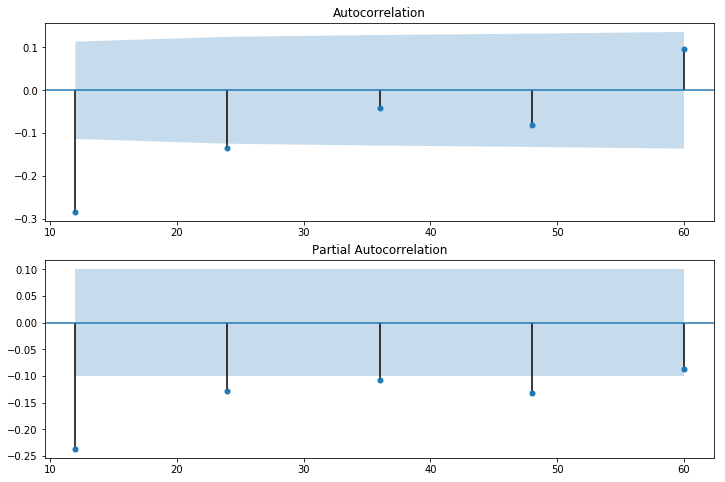

In [29]:
#ACF and PACF of the yearly lags
lags = [12, 24, 36, 48, 60]
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(df_diff, lags=[12,24,36,48,60], zero=False, ax=ax1)
plot_pacf(df_diff, lags=[12,24,36,48,60], zero=False, ax=ax2)
plt.show()

<p> The ACF shows us that the seasonal cycle happens every 12 periods; there is a spike at lag 12 which indicates this. Knowing this, we can perform decomposition by setting freq = 12, which specifies the seasonal length<p/>
<p> The ACF and PACF will also give us an idea of what our SARIMA model's initial paramters AR(p) and MA(q) will be set to;<p/>
<li>The ACF will cut off after p lags, and the PACF will cut off after q lags.
<li>If the ACF tails off, then p may be set to 0. If the PACF tails off, then q may be set to 0.
<p>With this in mind, we will begin with an initial SARIMA of (2,1,2)(4,1,2)12

### Estimation
<p>We can begin the estimation phase

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           Turnover   No. Observations:                  393
Model:             SARIMAX(2, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -1150.585
Date:                            Mon, 19 Jul 2021   AIC                           2323.171
Time:                                    23:30:59   BIC                           2366.513
Sample:                                04-01-1982   HQIC                          2340.369
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8017      0.431      1.861      0.063      -0.043       1.646
ar.L2         -0.2730      0.161   

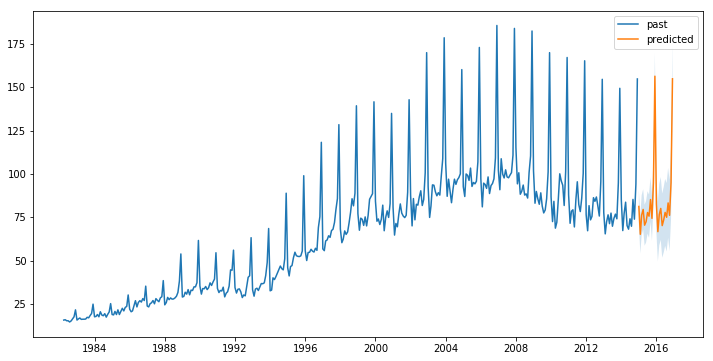

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['Turnover'], order=(2,1,2), seasonal_order=(4,1,2,12))
results = model.fit()

forecast_object = results.get_forecast(steps=24)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
print(results.summary())

plt.figure()
plt.plot(df.index.values, df.values, label='past')
plt.plot(dates, mean, label='predicted')
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.legend()
plt.show()

In [33]:
#Display our predicted values for the next 2 years
mean

2015-01-01     81.230942
2015-02-01     65.157794
2015-03-01     76.295632
2015-04-01     79.520134
2015-05-01     70.416100
2015-06-01     72.478621
2015-07-01     77.742374
2015-08-01     75.623506
2015-09-01     85.228247
2015-10-01     74.372176
2015-11-01     95.062871
2015-12-01    156.492738
2016-01-01     82.577615
2016-02-01     66.674104
2016-03-01     76.515030
2016-04-01     80.091281
2016-05-01     70.180990
2016-06-01     73.464005
2016-07-01     77.802423
2016-08-01     74.992837
2016-09-01     83.276250
2016-10-01     76.109754
2016-11-01     95.034359
2016-12-01    154.981038
Freq: MS, dtype: float64